In [21]:
import pandas as pd
import os

# 1. 병합할 경로 지정
base_path = "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보"
months = ['07', '08', '09', '10', '11', '12']
file_paths = [os.path.join(base_path, f"2018{month}_train_신용정보.parquet") for month in months]

# 2. 병합 리스트
df_list = []
for path in file_paths:
    df = pd.read_parquet(path)
    df['기준년월'] = os.path.basename(path).split('_')[0]  # 기준년월 컬럼 추가
    df_list.append(df)

# 3. 병합 수행
merged_df = pd.concat(df_list, ignore_index=True)

# 4. 결과 확인
print("병합된 데이터프레임 크기:", merged_df.shape)
print("컬럼 목록:")
print(merged_df.columns.tolist())

병합된 데이터프레임 크기: (2400000, 42)
컬럼 목록:
['기준년월', 'ID', '최초한도금액', '카드이용한도금액', 'CA한도금액', '일시상환론한도금액', '월상환론한도금액', 'CA이자율_할인전', 'CL이자율_할인전', 'RV일시불이자율_할인전', 'RV현금서비스이자율_할인전', 'RV신청일자', 'RV약정청구율', 'RV최소결제비율', '자발한도감액횟수_R12M', '자발한도감액금액_R12M', '자발한도감액후경과월', '강제한도감액횟수_R12M', '강제한도감액금액_R12M', '강제한도감액후경과월', '한도증액횟수_R12M', '한도증액금액_R12M', '한도증액후경과월', '상향가능한도금액', '상향가능CA한도금액', '카드론동의여부', '월상환론상향가능한도금액', 'RV전환가능여부', '일시불ONLY전환가능여부', '카드이용한도금액_B1M', '카드이용한도금액_B2M', '특별한도보유여부_R3M', '연체감액여부_R3M', '한도심사요청건수', '한도요청거절건수', '한도심사요청후경과월', '한도심사거절후경과월', '시장단기연체여부_R6M', '시장단기연체여부_R3M', '시장연체상환여부_R6M', '시장연체상환여부_R3M', 'rv최초시작후경과일']


In [3]:
from sklearn.preprocessing import LabelEncoder

# 1. 복사본 생성 (원본 보존하고 싶을 경우)
encoded_df = merged_df.copy()

# 2. 문자형 컬럼을 Label Encoding
for col in encoded_df.columns:
    if encoded_df[col].dtype == 'object' or encoded_df[col].dtype.name == 'category':
        encoded_df[col] = LabelEncoder().fit_transform(encoded_df[col].astype(str))

# 3. 확인
print("문자형 → 수치형 변환 완료")
print("변환된 데이터 타입:")
print(encoded_df.dtypes.value_counts())

문자형 → 수치형 변환 완료
변환된 데이터 타입:
int64      28
int32       7
float64     7
Name: count, dtype: int64


In [4]:
# 1. 표준편차 0인 컬럼 제거
std_0_cols = encoded_df.columns[encoded_df.std() == 0].tolist()
print("표준편차 0인 컬럼:", std_0_cols)
encoded_df = encoded_df.drop(columns=std_0_cols)

# 2. 결측치 비율 30% 이상 컬럼 제거
null_ratio = encoded_df.isnull().mean()
high_null_cols = null_ratio[null_ratio > 0.3].index.tolist()
print("결측치 비율 > 30% 컬럼:", high_null_cols)
encoded_df = encoded_df.drop(columns=high_null_cols)

# 3. 결과 요약
print("✅ 정리된 컬럼 수:", encoded_df.shape[1])

표준편차 0인 컬럼: ['시장연체상환여부_R3M']
결측치 비율 > 30% 컬럼: ['RV신청일자']
✅ 정리된 컬럼 수: 40


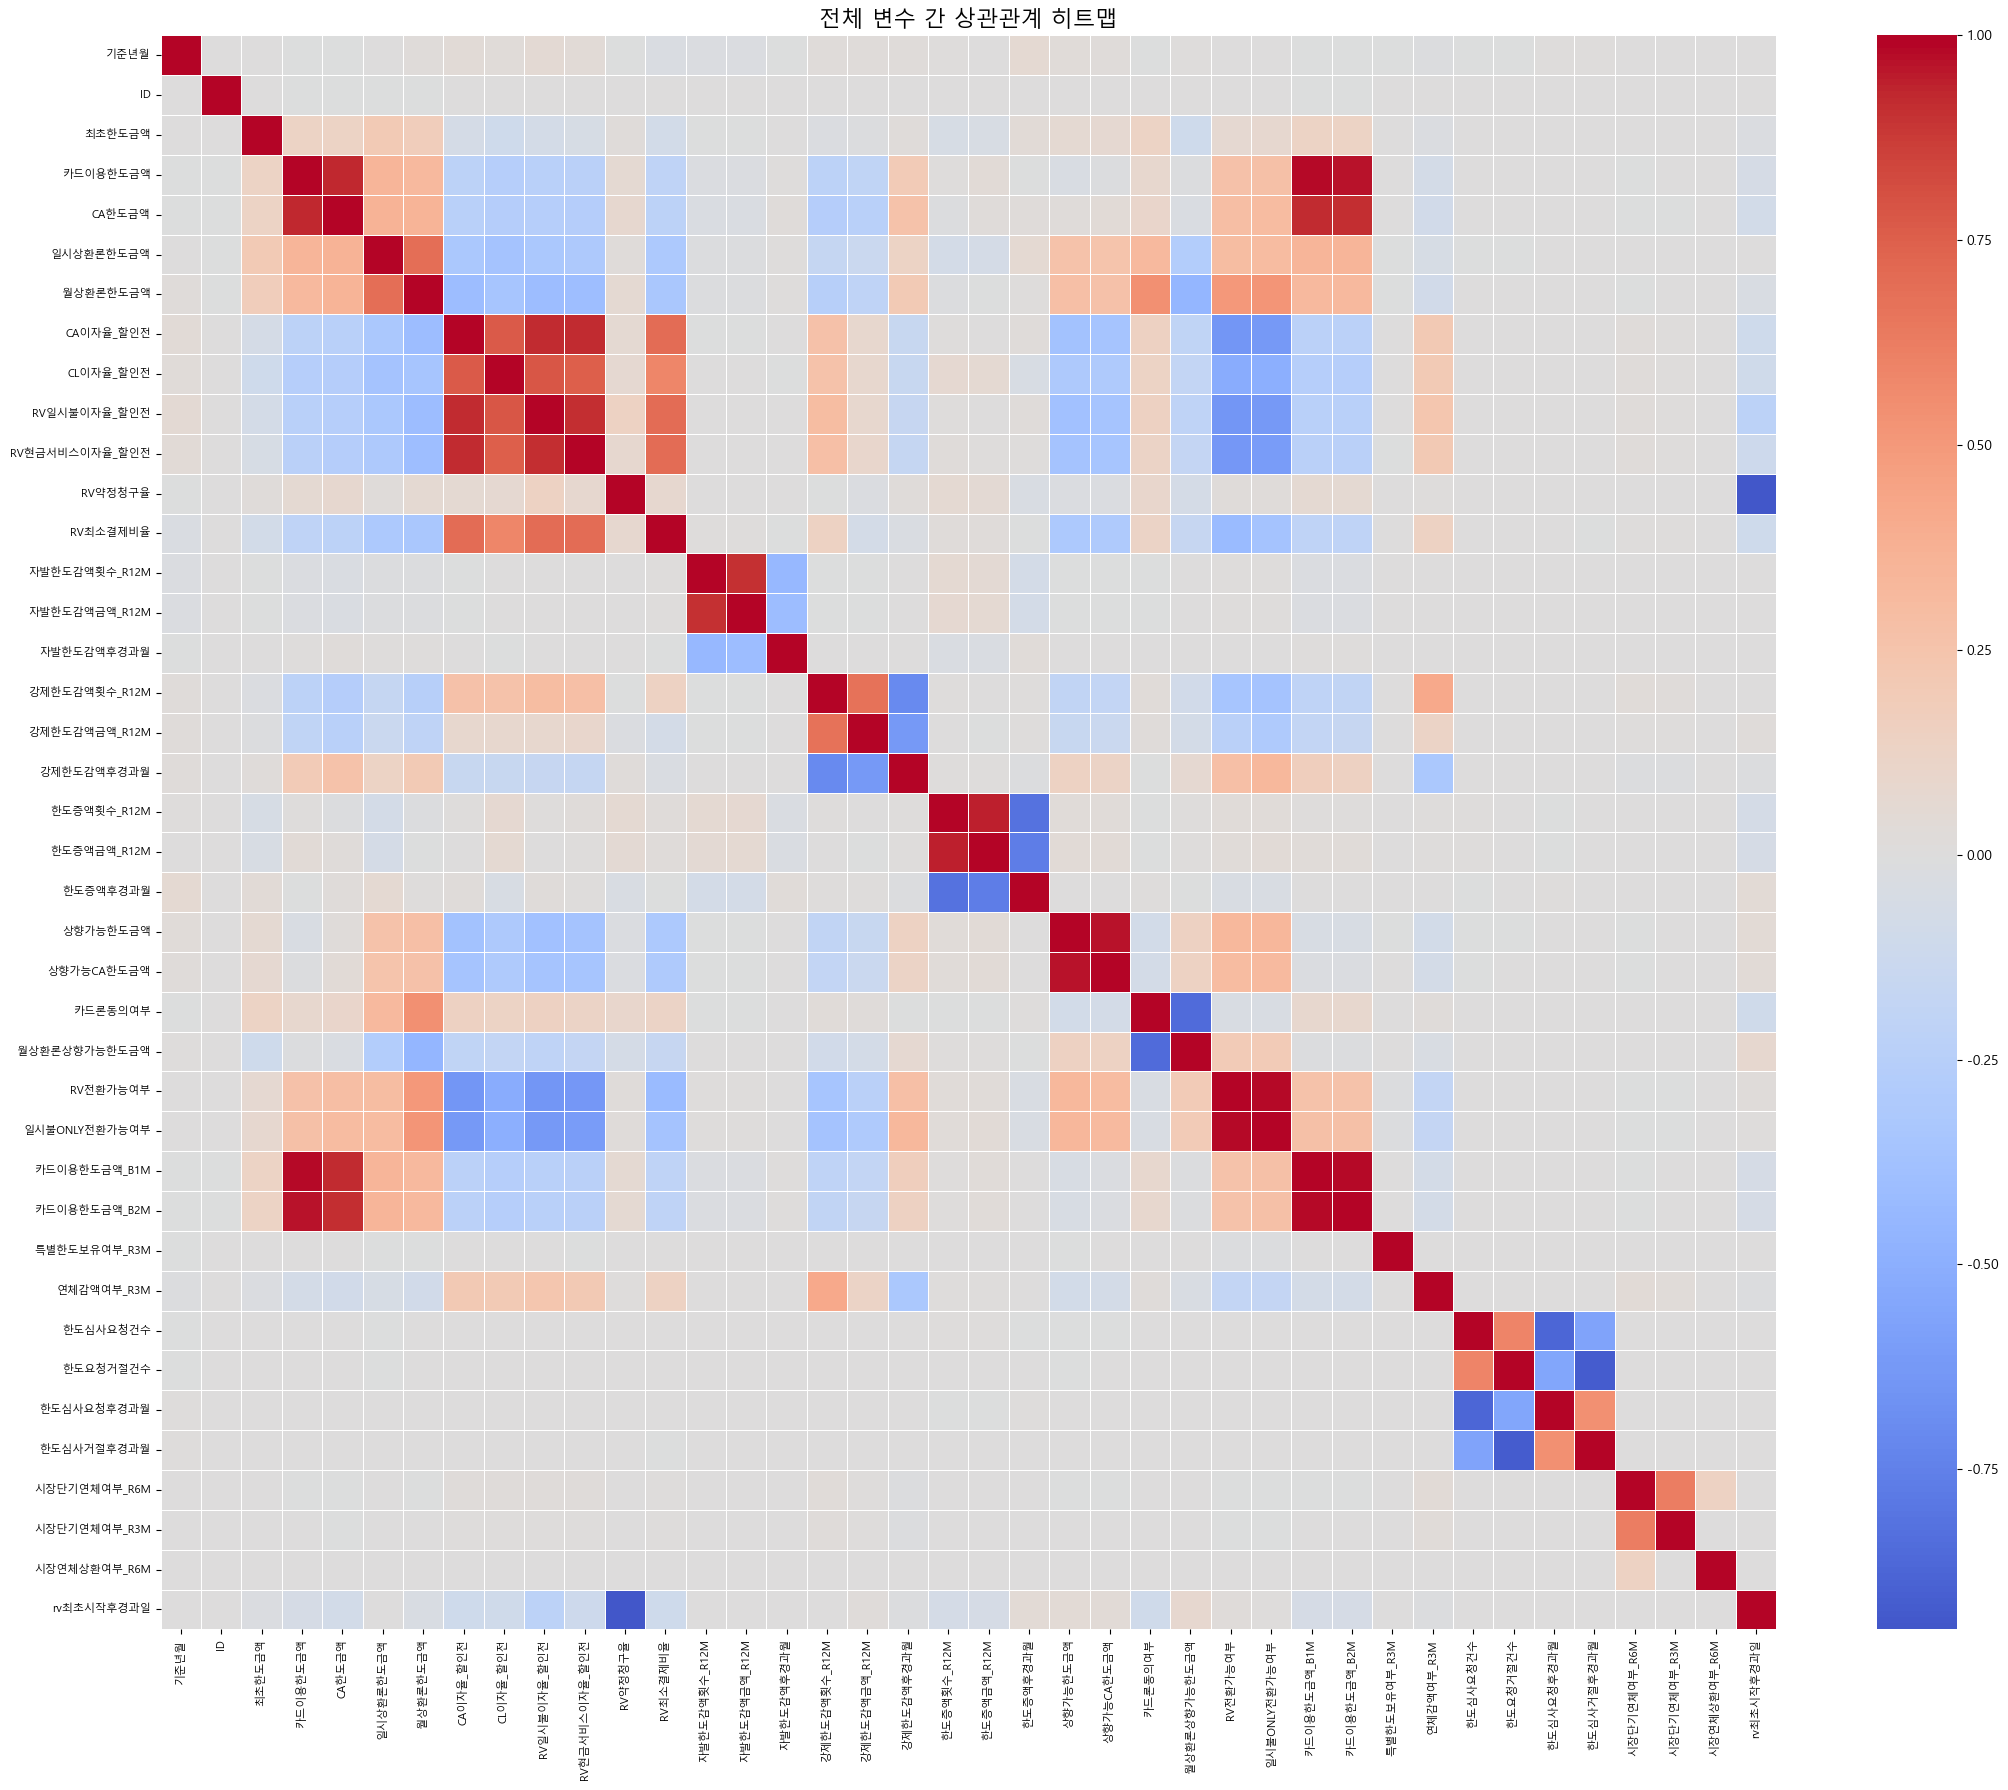

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# 1. 상관계수 계산
corr_matrix = encoded_df.corr()

# 2. 한글 폰트 설정 (윈도우 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# 3. 히트맵 시각화
plt.figure(figsize=(22, 18))  # 넓고 크게
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    square=False,
    cbar=True,
    linewidths=0.5
)

plt.title("전체 변수 간 상관관계 히트맵", fontsize=16)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


In [20]:
# 1. 절댓값 기준으로 상관계수 추출
threshold = 0.5
corr_pairs = corr_matrix.abs().unstack()

# 2. 자기 자신과의 상관 (항상 1) 제거
corr_pairs = corr_pairs[corr_pairs < 1]

# 3. 중복 쌍 제거 (A-B, B-A)
corr_pairs = corr_pairs.drop_duplicates()

# 4. 0.5 이상 필터링
strong_corr = corr_pairs[corr_pairs >= threshold].sort_values(ascending=False)

# 5. 결과 확인
print("상관계수 0.5 이상인 변수쌍 개수:", strong_corr.shape[0])
print(strong_corr)

상관계수 0.5 이상인 변수쌍 개수: 28
카드이용한도금액_B1M    카드이용한도금액_B2M      0.988965
카드이용한도금액        카드이용한도금액_B1M      0.983252
                카드이용한도금액_B2M      0.977768
상향가능한도금액        상향가능CA한도금액        0.959941
RV약정청구율         rv최초시작후경과일        0.945217
CA이자율_할인전       RV현금서비스이자율_할인전    0.926360
카드이용한도금액        CA한도금액            0.926023
CA한도금액          카드이용한도금액_B1M      0.923802
                카드이용한도금액_B2M      0.920331
RV일시불이자율_할인전    RV현금서비스이자율_할인전    0.918426
CA이자율_할인전       RV일시불이자율_할인전      0.903950
CL이자율_할인전       RV일시불이자율_할인전      0.778856
자발한도감액금액_R12M   자발한도감액후경과월        0.765819
CL이자율_할인전       RV현금서비스이자율_할인전    0.754798
CA이자율_할인전       CL이자율_할인전         0.743905
RV현금서비스이자율_할인전  RV최소결제비율          0.692631
일시상환론한도금액       월상환론한도금액          0.684968
RV일시불이자율_할인전    RV최소결제비율          0.674108
CA이자율_할인전       RV최소결제비율          0.673041
강제한도감액횟수_R12M   강제한도감액후경과월        0.657506
                강제한도감액금액_R12M     0.648968
한도증액금액_R12M     한도증액후경과월          0.645042
RV일시불이자율_할인전    일시불ONLY전환가능여부 

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager

# 윈도우 사용자용 - Malgun Gothic 설치돼 있다고 가정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 말굿고딕 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()

plt.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False

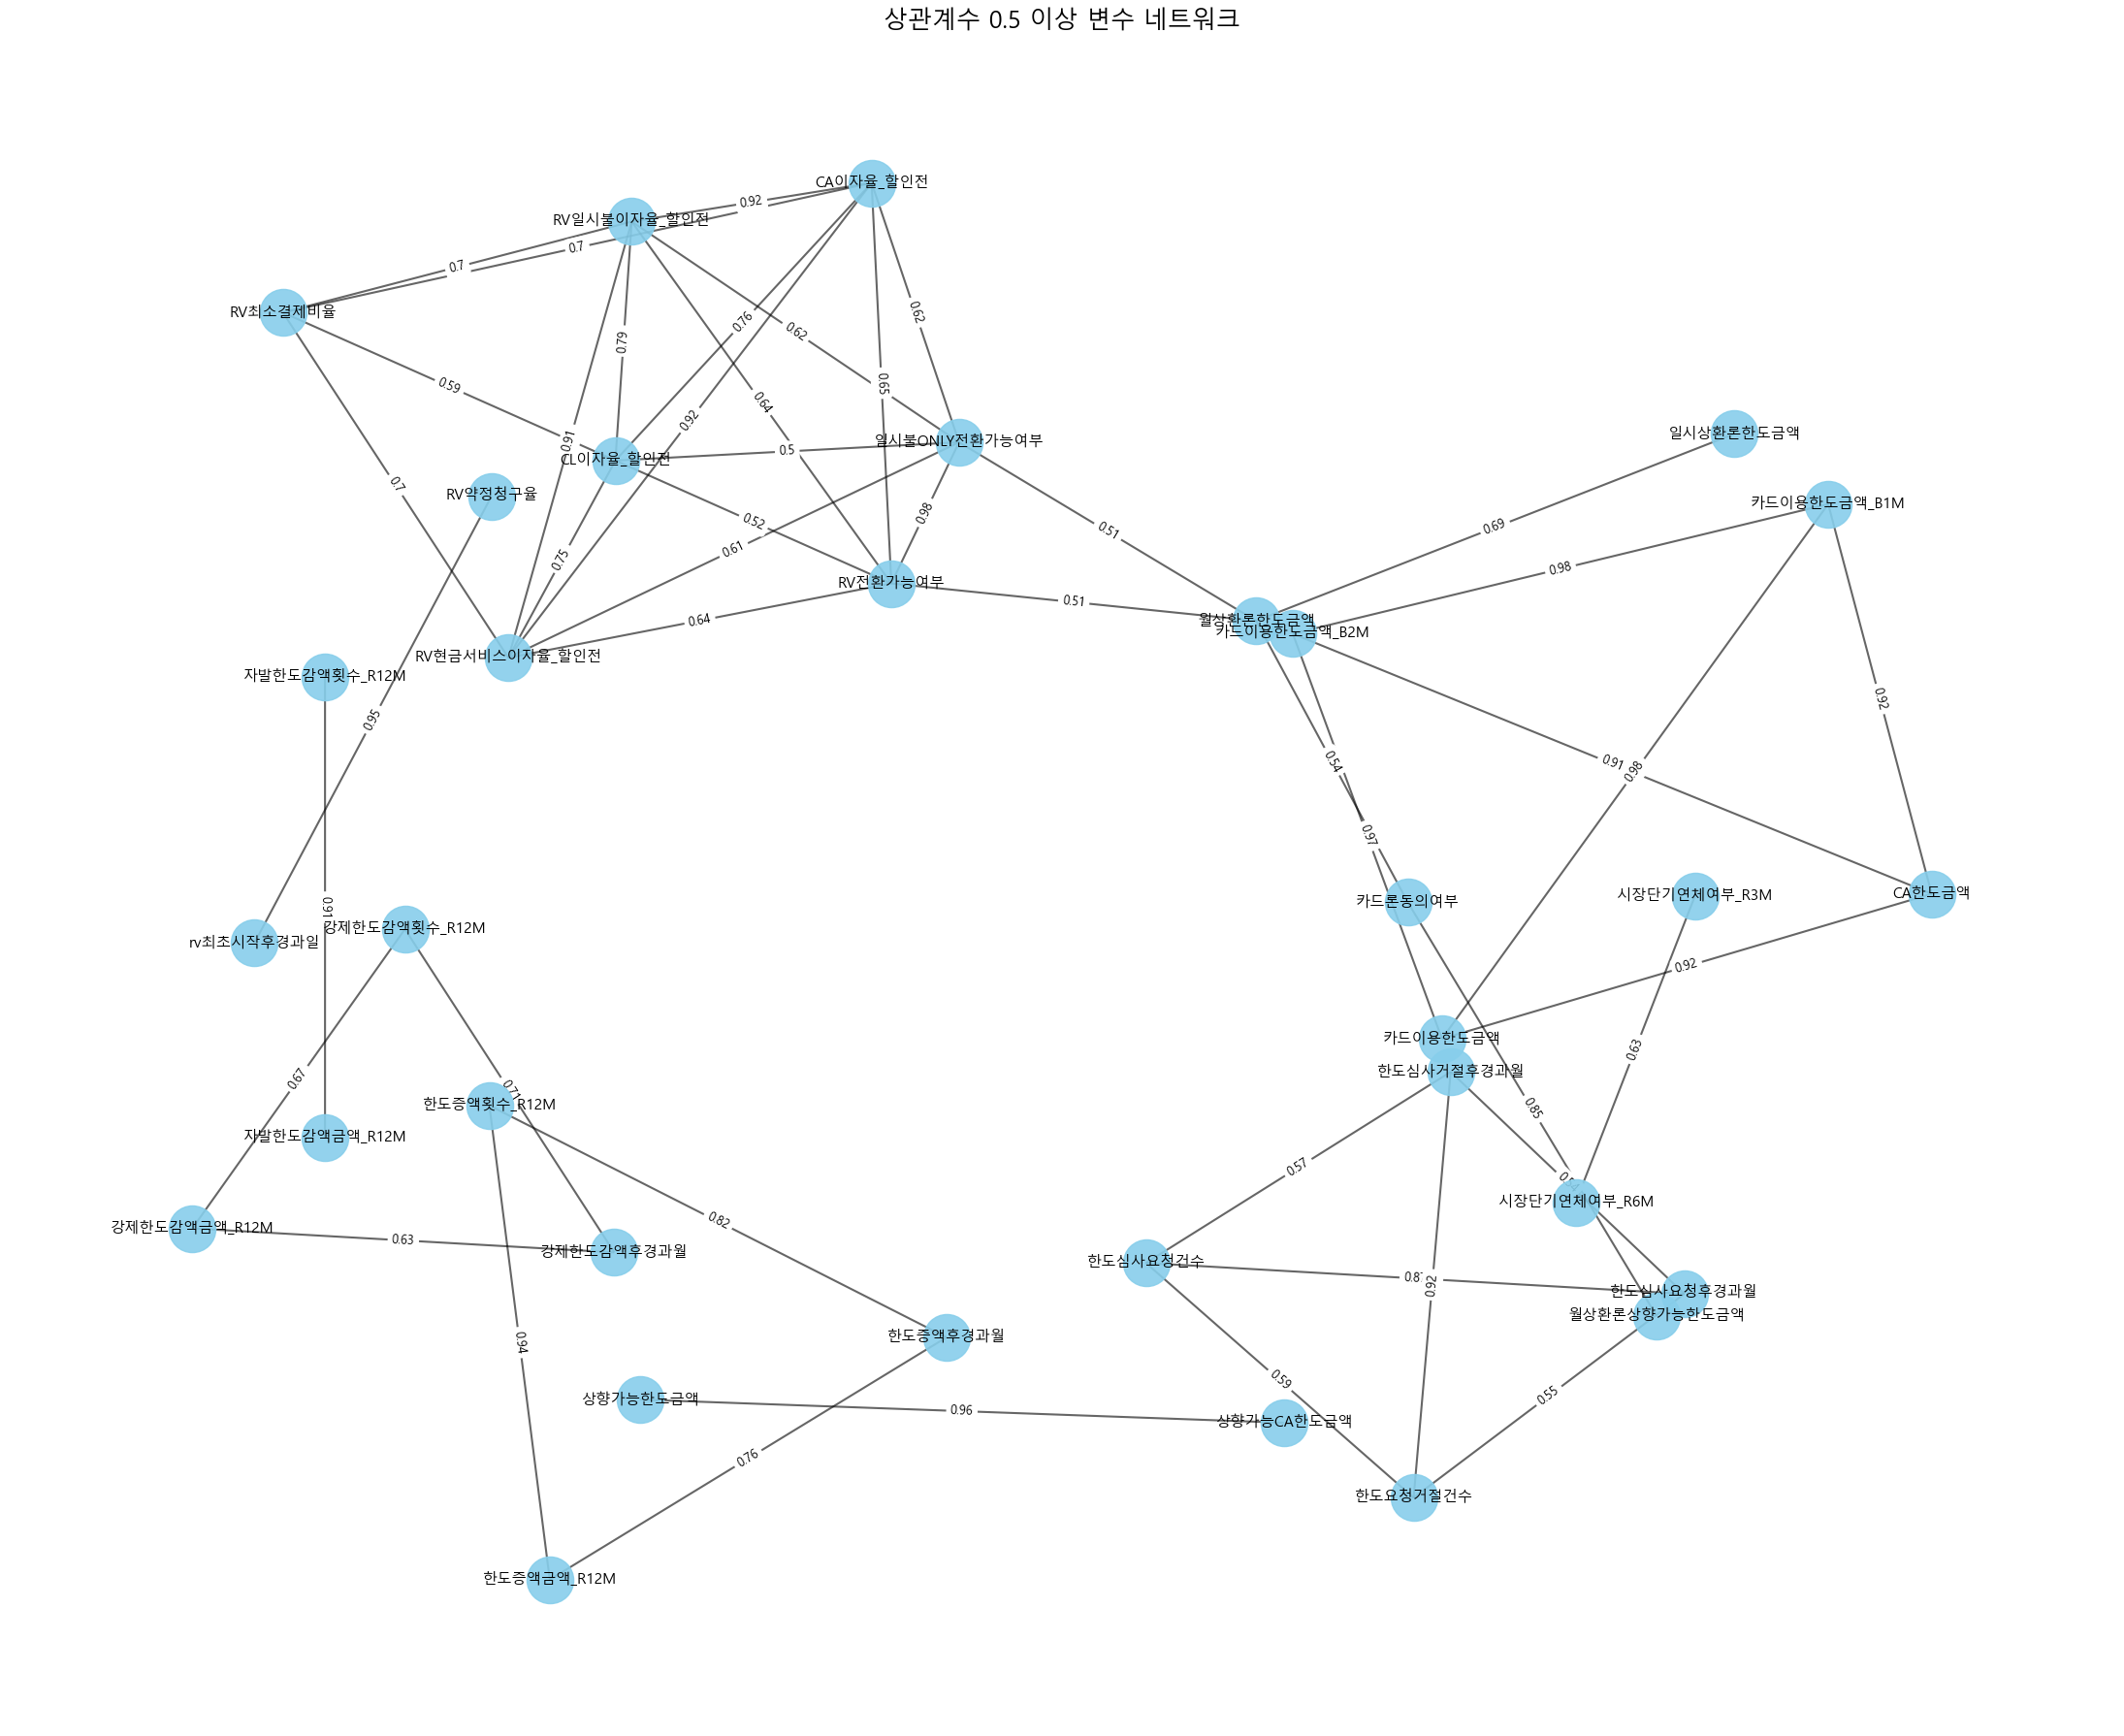

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager

# 1. 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_prop
mpl.rcParams['axes.unicode_minus'] = False

# 2. 상관계수 0.5이상 페어 추출
threshold = 0.5
corr_pairs = corr_matrix.abs().unstack()
corr_pairs = corr_pairs[corr_pairs < 1].drop_duplicates()
strong_corr = corr_pairs[corr_pairs >= threshold]

# 3. 그래프 생성
G = nx.Graph()
for (var1, var2), corr in strong_corr.items():
    G.add_edge(var1, var2, weight=round(corr, 2))

# 4. 가독성 향상: 배치 조정, 폰트/간격 확대
plt.figure(figsize=(22, 18))
pos = nx.kamada_kawai_layout(G)  # 🔸 거리 기반 균형 배치

# 노드 그리기
nx.draw_networkx_nodes(G, pos, node_size=1200, node_color='skyblue', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.6)

# 텍스트 가독성 개선
nx.draw_networkx_labels(G, pos, font_size=11, font_family=font_prop)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_family=font_prop)

plt.title("상관계수 0.5 이상 변수 네트워크", fontsize=18, fontname=font_prop)
plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
import os

# 1. 회원정보 파일 경로 리스트
member_file_paths = [
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201807_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201808_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201809_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201810_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201811_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201812_train_회원정보.parquet"
]

# 2. 마케팅정보 파일 경로 리스트
marketing_file_paths = [
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201807_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201808_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201809_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201810_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201811_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201812_train_신용정보.parquet"
]

# 3. 기준년월 컬럼 추가 및 병합 함수
def load_and_merge_parquet(file_paths):
    df_list = []
    for path in file_paths:
        df = pd.read_parquet(path)
        기준년월 = os.path.basename(path).split('_')[0]
        df['기준년월'] = 기준년월
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

# 4. 데이터 로딩
member_df = load_and_merge_parquet(member_file_paths)
marketing_df = load_and_merge_parquet(marketing_file_paths)

# 5. Segment 컬럼 자동 탐색 및 숫자형 변환
segment_col_candidates = [col for col in member_df.columns if 'segment' in col.lower()]
print("사용 가능한 segment 컬럼 후보:", segment_col_candidates)
segment_col = segment_col_candidates[-1]

if member_df[segment_col].dtype == 'object':
    member_df[segment_col] = member_df[segment_col].astype('category').cat.codes

# 6. 두 DataFrame을 'ID'와 '기준년월' 기준으로 inner join (병합 아님, 동기화)
target_cols = ['ID', '기준년월', segment_col]
member_target = member_df[target_cols]
combined_df = pd.merge(member_target, marketing_df, on=['ID', '기준년월'], how='inner')

# 7. 분석 대상 numeric 컬럼만 선택
numeric_cols = [col for col in combined_df.select_dtypes(include=['int64', 'float64']).columns if col != segment_col]

# 8. 결측치 제거 및 std=0 컬럼 제거
clean_df = combined_df[numeric_cols + [segment_col]].dropna()
clean_df = clean_df.loc[:, clean_df.std() != 0]
numeric_cols = [col for col in numeric_cols if col in clean_df.columns]

# 9. 결측치 수 계산
missing_dict = {
    col: combined_df[col].isnull().sum()
    for col in numeric_cols
}

# 10. 이상치 수 계산 (IQR 기준)
outlier_dict = {}
for col in numeric_cols:
    Q1 = combined_df[col].quantile(0.25)
    Q3 = combined_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((combined_df[col] < lower_bound) | (combined_df[col] > upper_bound)).sum()
    outlier_dict[col] = outliers

# 11. 상관계수 계산
corr_dict = {
    col: clean_df[segment_col].corr(clean_df[col])
    for col in numeric_cols
}

# 12. 결과 정리
corr_df = pd.DataFrame({
    '컬럼명': list(corr_dict.keys()),
    '상관계수': list(corr_dict.values()),
    '결측치 수': [missing_dict[col] for col in corr_dict.keys()],
    '이상치 수': [outlier_dict[col] for col in corr_dict.keys()]
})

corr_df = corr_df.sort_values(by='상관계수', key=abs, ascending=False)

# 13. 스타일링 출력
from IPython.display import display
styled = corr_df.style.background_gradient(cmap='coolwarm', subset=['상관계수']) \
                    .set_properties(**{'text-align': 'center'}) \
                    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
display(styled)

사용 가능한 segment 컬럼 후보: ['Segment']


,컬럼명,상관계수,결측치 수,이상치 수
1,카드이용한도금액,-0.284751,0,155531
24,카드이용한도금액_B2M,-0.282935,0,158297
23,카드이용한도금액_B1M,-0.282312,0,157572
2,CA한도금액,-0.280853,0,55136
5,CA이자율_할인전,-0.106931,0,544496
0,최초한도금액,-0.088260,0,328716
10,RV약정청구율,0.079446,0,454949
7,RV일시불이자율_할인전,-0.074411,0,269448
8,RV현금서비스이자율_할인전,-0.071617,0,452238
9,RV신청일자,0.057772,1951236,0


In [14]:
# Segment와 상관관계 ≥ 0.2인 변수 추출
segment_related = corr_df[corr_df['상관계수'].abs() >= 0.2]

# 결과 확인
print("Segment와 상관관계 ≥ 0.2 변수 목록:")
print(segment_related[['컬럼명', '상관계수']].sort_values(by='상관계수', key=abs, ascending=False))



Segment와 상관관계 ≥ 0.2 변수 목록:
             컬럼명      상관계수
1       카드이용한도금액 -0.284751
24  카드이용한도금액_B2M -0.282935
23  카드이용한도금액_B1M -0.282312
2         CA한도금액 -0.280853


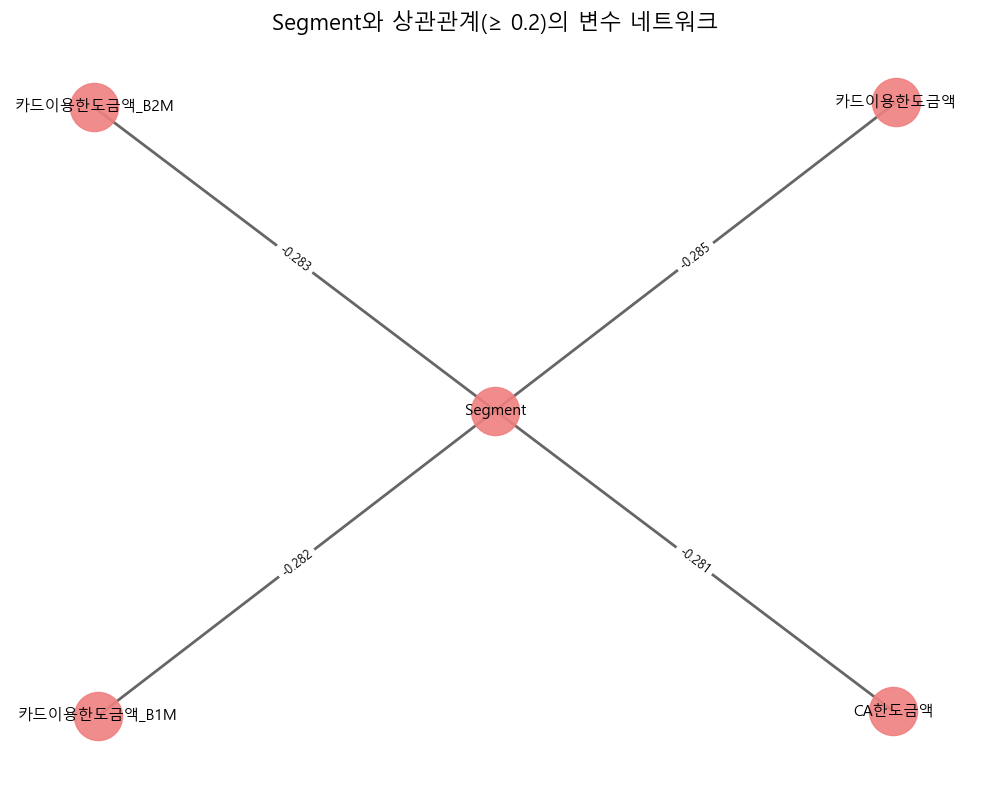

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import font_manager

# 📌 상관계수 ≥ 0.2인 변수만 필터
segment_related = corr_df[corr_df['상관계수'].abs() >= 0.2].set_index('컬럼명')

# 📌 그래프 생성 (weight는 abs로, label은 원래 값 유지)
G = nx.Graph()
for var in segment_related.index:
    corr_val = segment_related.loc[var, '상관계수']
    G.add_edge('Segment', var, weight=abs(corr_val), label=round(corr_val, 3))  # label은 실제값

# 📌 노드 리스트 및 서브그래프
segment_nodes = ['Segment'] + segment_related.index.tolist()
G_sub = G.subgraph(segment_nodes)

# 📌 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = font_manager.FontProperties(fname=font_path).get_name()

# 📌 시각화
if len(G_sub.edges) == 0:
    print("⚠️ 시각화할 연결이 없습니다.")
else:
    plt.figure(figsize=(10, 8))
    pos = nx.kamada_kawai_layout(G_sub, weight='weight')  # ← 절댓값 기준 layout

    nx.draw_networkx_nodes(G_sub, pos, node_size=1200, node_color='lightcoral', alpha=0.9)
    nx.draw_networkx_edges(G_sub, pos, width=2, alpha=0.6)
    nx.draw_networkx_labels(G_sub, pos, font_size=11, font_family=font_prop)

    # 실제 부호 있는 상관계수 출력
    edge_labels = nx.get_edge_attributes(G_sub, 'label')
    nx.draw_networkx_edge_labels(G_sub, pos, edge_labels=edge_labels, font_size=9, font_family=font_prop)

    plt.title("Segment와 상관관계(≥ 0.2)의 변수 네트워크", fontsize=16, fontname=font_prop)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

